# **CSE 7324 Lab 3: Extending Logistic Regression**
### *Thomas Adams, Suleiman Hijazeen, Nancy Le and Andrew Whigham*
------

### **1. Preparation and Overview**
------

In [366]:
# dependencies for lab 1
import pandas as pd
import numpy as np
import missingno as msno
# use plotly in offline mode to not have active connection to plotly servers
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import warnings
#warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")
%matplotlib inline


In [599]:
# import data
shelter_outcomes = pd.read_csv("C:/Users/sulem/OneDrive/Desktop/machin learnign/Project3/aac_shelter_cat_outcome_eng.csv")
# filter animal type for just cats
cats = shelter_outcomes[shelter_outcomes['animal_type'] == 'Cat']
#print(cats.head())

# remove age_upon_outcome and recalculate to standard units (days)
age = cats.loc[:,['datetime', 'date_of_birth']]
# convert to datetime
age.loc[:,'datetime'] = pd.to_datetime(age['datetime'])
age.loc[:,'date_of_birth'] = pd.to_datetime(age['date_of_birth'])
# calculate cat age in days
cats.loc[:,'age'] = (age.loc[:,'datetime'] - age.loc[:,'date_of_birth']).dt.days
# get dob info
cats['dob_month'] = age.loc[:, 'date_of_birth'].dt.month
cats['dob_day'] = age.loc[:, 'date_of_birth'].dt.day
cats['dob_dayofweek'] = age.loc[:, 'date_of_birth'].dt.dayofweek
# get month from datetime
cats['month'] = age.loc[:,'datetime'].dt.month
# get day of month
cats['day'] = age.loc[:,'datetime'].dt.day
# get day of week
cats['dayofweek'] = age.loc[:, 'datetime'].dt.dayofweek
# get hour of day
cats['hour'] = age.loc[:, 'datetime'].dt.hour
# get quarter
cats['quarter'] = age.loc[:, 'datetime'].dt.quarter

# clean up breed attribute
# get breed attribute for processing
# convert to lowercase, remove mix and strip whitespace
# remove space in 'medium hair' to match 'longhair' and 'shorthair'
# split on either space or '/'
breed = cats.loc[:, 'breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip().str.split('/', expand=True)
cats['breed'] = breed[0]
cats['breed1'] = breed[1]

# clean up color attribute
# convert to lowercase
# strip spaces
# split on '/'
color = cats.loc[:, 'color'].str.lower().str.strip().str.split('/', expand=True)
cats['color'] = color[0]
cats['color1'] = color[1]

# clean up sex_upon_outcome
sex = cats['sex_upon_outcome'].str.lower().str.strip().str.split(' ', expand=True)
sex[0].replace('spayed', True, inplace=True)
sex[0].replace('neutered', True, inplace=True)
sex[0].replace('intact', False, inplace=True)
sex[1].replace(np.nan, 'unknown', inplace=True)
cats['spayed_neutered'] = sex[0]
cats['sex'] = sex[1]

# add in domesticated attribute
cats['domestic'] = np.where(cats['breed'].str.contains('domestic'), 1, 0)

# combine outcome and outcome subtype into a single attribute
cats['outcome_subtype'] = cats['outcome_subtype'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome_type'] = cats['outcome_type'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome'] = cats['outcome_type'] + '_' + cats['outcome_subtype']

# drop unnecessary columns
cats.drop(columns=['animal_id', 'name', 'animal_type', 'age_upon_outcome', 'date_of_birth', 'datetime', 'monthyear', 'sex_upon_outcome', 'outcome_subtype', 'outcome_type'], inplace=True)
#print(cats['outcome'].value_counts())

cats.head()

,breed,color,count,sex,Spay/Neuter,Periods,Period Range,outcome_age_(days),outcome_age_(years),Cat/Kitten (outcome),...,dob_day,dob_dayofweek,month,day,dayofweek,hour,quarter,spayed_neutered,domestic,outcome
0,domestic shorthair,orange,1,male,No,2,7,14,0.038356,Kitten,...,7,0,7,22,1,16,3,False,1,transfer_partner
1,domestic shorthair,blue,1,female,No,1,30,30,0.082192,Kitten,...,16,0,8,14,3,18,3,False,1,adoption_unknown
2,domestic shorthair,white,1,female,Yes,3,30,90,0.246575,Kitten,...,26,2,6,29,6,17,2,True,1,adoption_offsite
3,domestic mediumhair,black,1,female,Yes,1,365,365,1.000000,Cat,...,27,2,3,28,4,14,1,True,1,return-to-owner_unknown
4,domestic shorthair,black,1,male,No,3,7,21,0.057534,Kitten,...,16,0,1,9,3,19,1,False,1,transfer_partner


In [600]:
cats.drop(columns=['breed1'], inplace=True)
cats.drop(columns=['color2'], inplace=True)
cats.drop(columns=['breed2'], inplace=True)
cats.drop(columns=['coat_pattern'], inplace=True)
cats.drop(columns=['Cat/Kitten (outcome)'], inplace=True)
cats.drop(columns=['sex_age_outcome'], inplace=True)
cats.drop(columns=['dob_monthyear'], inplace=True)
cats.drop(columns=['outcome_weekday'], inplace=True)
#Breed, Color, Color1, Spayed_Netured and Sex attributes need to be one hot encoded
cats_ohe = pd.get_dummies(cats, columns=['breed', 'color', 'color1', 'spayed_neutered', 'sex','Spay/Neuter','age_group','coat','domestic_breed','cfa_breed' ])
#out_t={'euthanasia_rabies-risk' : 1, 'unknown_unknown' : 2, 'adoption_barn' : 3, 'died_unknown' : 4, 'adoption_offsite' : 5, 'adoption_unknown' : 6, 'missing_in-foster' : 7, 'rto-adopt_unknown' : 8, 'died_enroute' : 9, 'died_in-surgery' : 10, 'transfer_snr' : 11, 'euthanasia_medical' : 12, 'euthanasia_aggressive' : 13, 'transfer_scrp' : 15, 'euthanasia_unknown' : 14, 'missing_unknown' : 16, 'died_in-foster' : 17, 'missing_possible-theft' : 18, 'adoption_foster' : 19, 'euthanasia_at-vet' : 20, 'missing_in-kennel' : 21, 'died_at-vet' : 22, 'transfer_partner' : 23, 'return-to-owner_unknown' : 25, 'disposal_unknown' : 24, 'euthanasia_underage' : 26, 'died_in-kennel' : 27, 'euthanasia_suffering' : 28, 'transfer_barn' : 29}
#out_t={'euthanasia_rabies-risk' : 1, 'unknown_unknown' : 2, 'adoption_barn' : 3, 'died_unknown' : 4, 'adoption_offsite' : 5, 'adoption_unknown' : 6, 'missing_in-foster' : 7, 'rto-adopt_unknown' : 8, 'died_enroute' : 9, 'died_in-surgery' : 10, 'transfer_snr' : 11, 'euthanasia_medical' : 12, 'euthanasia_aggressive' : 13, 'transfer_scrp' : 15, 'euthanasia_unknown' : 14, 'missing_unknown' : 16, 'died_in-foster' : 0, 'missing_possible-theft' : 0, 'adoption_foster' : 0, 'euthanasia_at-vet' : 0, 'missing_in-kennel' : 0, 'died_at-vet' : 0, 'transfer_partner' : 0, 'return-to-owner_unknown' : 0, 'disposal_unknown' : 0, 'euthanasia_underage' : 0, 'died_in-kennel' : 0, 'euthanasia_suffering' : 0, 'transfer_barn' : 0}
out_t={'euthanasia_suffering' : 0, 'died_in-kennel' : 0, 'return-to-owner_unknown' : 0, 'transfer_partner' : 1, 'euthanasia_at-vet' : 2, 'adoption_foster' : 3, 'died_in-foster' : 0, 'transfer_scrp' : 4, 'euthanasia_medical' : 0, 'transfer_snr' : 0, 'died_enroute' : 0, 'rto-adopt_unknown' : 0, 'missing_in-foster' : 0, 'adoption_offsite' : 0, 'adoption_unknown' :5,'euthanasia_rabies-risk' : 0, 'unknown_unknown' : 0, 'adoption_barn' : 0, 'died_unknown' : 0, 'died_in-surgery' : 0, 'euthanasia_aggressive' : 0, 'euthanasia_unknown' : 0, 'missing_unknown' : 0, 'missing_in-kennel' : 0, 'missing_possible-theft' : 0, 'died_at-vet' : 0, 'disposal_unknown' : 0, 'euthanasia_underage' : 0, 'transfer_barn' : 0}

cats_ohe.head()

# separate outcome from data
outcome = cats_ohe['outcome']
cats_ohe.drop(columns=['outcome'])

# split the data
X_train, X_test, y_train, y_test = train_test_split(cats_ohe, outcome, test_size=0.2, random_state=0)
X_train.drop(columns=['outcome'], inplace=True)
y_train = [out_t[item] for item in y_train]
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [601]:
import numpy as np
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations, C,reg):
        self.eta = eta
        self.iters = iterations
        self.C=C
        self.reg=reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    # inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_bias=False))*xi 
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape) 
        
        return gradient/float(len(y))
       
    # public:
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
import numpy as np
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if self.reg=='L2':
         gradient[1:] += -2 * self.w_[1:] * self.C
        if self.reg=='L1':
         gradient[1:] += -self.C
        if self.reg=='L1L2':
         gradient[1:] += -self.C-2 * self.w_[1:] * self.C
        if self.reg=='none':
         gradient[1:]
        return gradient
    
    
from scipy.optimize import minimize_scalar
import copy
class LineSearchLogisticRegression(VectorBinaryLogisticRegression):
    
    # define custom line search for problem
    
    @staticmethod
    def objective_function(eta,X,y,w,grad,C=0.001):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
    
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization inopposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/50} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,0.001), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if self.reg=='L2':
         gradient[1:] += -2 * self.w_[1:] * self.C
        if self.reg=='L1':
         gradient[1:] += -self.C
        if self.reg=='L1L2':
         gradient[1:] += -self.C-(2 * self.w_[1:] * self.C)
        if self.reg=='none':
         gradient[1:]
        return gradient
    
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C,reg):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C,reg):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        if reg=='L2':
         gradient[1:] += -2 * w[1:] * C
        if reg=='L1':
         gradient[1:] += - C
        if reg=='L1L2':
         gradient[1:] +=(-2 * w[1:] * C) - C
        if reg=='none':
         gradient[1:]
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C,self.reg), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))    
        
        
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if self.reg=='L2':
         gradient[1:] += -2 * self.w_[1:] * self.C
        if self.reg=='L1':
         gradient[1:] += -self.C
        if self.reg=='L1L2':
         gradient[1:] += -self.C-2 * self.w_[1:] * self.C
        if self.reg=='none':
         gradient[1:]
        return pinv(hessian) @ gradient

In [815]:
from scipy.optimize import minimize_scalar
import copy
class LogisticRegression:
    def __init__(self, eta, iterations,solver='leaner', C=0.001,reg='L2'):
        self.eta = eta
        self.iters = iterations
        self.slv  = solver
        self.C=C
        self.reg=reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            if self.slv=='stochastic':
             slr = StochasticLogisticRegression(self.eta,self.iters,self.C,self.reg)
             slr.fit(X,y_binary)
             self.classifiers_.append(slr)
            if self.slv=='steepest':
             mls=LineSearchLogisticRegression(self.eta,self.iters,self.C,self.reg)
             mls.fit(X,y_binary)
             self.classifiers_.append(mls)
            if self.slv=='leaner':
             blr = VectorBinaryLogisticRegression(self.eta,self.iters,self.reg)
             blr.fit(X,y_binary)
             self.classifiers_.append(blr)
            if self.slv=='BFGS':
             bfgslr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.C,self.reg)
             bfgslr.fit(X,y_binary)
             self.classifiers_.append(bfgslr)
            if self.slv=='newton':
             newt = HessianBinaryLogisticRegression(self.eta,self.iters,self.C,self.reg)
             newt.fit(X,y_binary)
             self.classifiers_.append(newt)
            
            # add the trained classifier to the list      
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
    
    
    
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row   
lr = LogisticRegression(0.1,500)
print(lr)


Untrained MultiClass Logistic Regression Object


In [676]:
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
#y_target_ar=y_train_b.transfer_partner.values
#y_target_ar=y_train_b_v
lr = LogisticRegression(.01,500,'stochastic',.01,'L1L2')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-0.005      -0.05215198 -0.17297558 ... -0.02377078 -0.03346551
  -0.06627228]
 [ 0.005      -0.04245245 -0.30421321 ...  0.01436998  0.01436998
  -0.10440824]
 [-0.015      -0.06169952 -0.15702452 ... -0.06169952 -0.06169952
  -0.04758582]
 [-0.005      -0.05224697 -0.20537343 ... -0.10115434 -0.10115434
   0.00132156]
 [-0.005      -0.05212505 -0.27899711 ... -0.03390101 -0.03390101
  -0.06580986]
 [ 0.005      -0.04235891  0.61953035 ... -0.02507575 -0.02507575
  -0.06486898]]
Accuracy of:  0.34355880353501017


In [618]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
lr = LogisticRegression(.01,3,'newton',.0001,'L2')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-1.26493232e+00 -8.06132888e-01  1.06514043e-03 ... -5.93871024e-01
  -5.87880563e-01 -6.03636183e-01]
 [ 8.54002121e-01  5.10132403e-01 -2.11737894e-03 ...  4.02990756e-01
   4.09631953e-01  3.87855793e-01]
 [-6.33087900e-02 -2.00755216e-02 -6.55337906e-06 ... -3.00809690e-02
  -3.01345837e-02 -3.00538788e-02]
 [-4.50675359e-01 -1.49797793e-01 -2.14253594e-03 ... -2.20246795e-01
  -2.18533621e-01 -2.03634239e-01]
 [ 2.38418030e+00  7.55584684e-01  4.37555503e-03 ...  1.12918037e+00
   1.12569793e+00  1.13587682e+00]
 [-1.40574938e+00 -7.50590474e-01 -1.17350375e-03 ... -6.51025489e-01
  -6.61777197e-01 -6.49405642e-01]]
Accuracy of:  0.572569680489463
Wall time: 1min 36s


In [686]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
lr = LogisticRegression(.1,10,'BFGS',.1,'none')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-3.42179002e-07 -3.42179002e-07 -9.74719719e-07 ... -3.24873073e-07
  -3.24450978e-07 -1.77280239e-08]
 [-1.60273891e-07 -1.60273891e-07 -5.96495250e-07 ... -1.48531859e-07
  -1.48124284e-07 -1.21496072e-08]
 [-4.28419043e-05 -4.28419043e-05 -1.37021925e-04 ... -4.03724989e-05
  -4.03196482e-05 -2.52225606e-06]
 [-6.64750903e-07 -6.64750903e-07 -2.14794347e-06 ... -6.28685097e-07
  -6.27844658e-07 -3.69062451e-08]
 [-1.01475491e-06 -1.01475491e-06 -5.73583629e-05 ...  3.33525122e-06
   3.26613571e-06 -4.28089062e-06]
 [-1.66100620e-07 -1.66100620e-07 -5.24855231e-07 ... -1.57596723e-07
  -1.57577783e-07 -8.52283682e-09]]
Accuracy of:  0.34721278042148196
Wall time: 2.26 s


In [816]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
lr = LogisticRegression(.01,10,'newton',.0001,'L1')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-4.04771055e+00 -2.80275539e+00  3.44944737e-03 ... -1.88323442e+00
  -1.86393993e+00 -1.91480593e+00]
 [ 2.87824109e+00  1.25242865e+00 -6.83028463e-03 ...  1.36457347e+00
   1.38610294e+00  1.31557067e+00]
 [-1.79880873e-01 -1.53044009e-01 -2.12613869e-05 ... -8.29658665e-02
  -8.31419569e-02 -8.28804002e-02]
 [-1.28771842e+00 -1.03494538e+00 -6.93004598e-03 ... -6.24415197e-01
  -6.18834521e-01 -5.70665413e-01]
 [ 6.71160376e+00  5.85703270e+00  1.41545256e-02 ...  3.09576603e+00
   3.08447452e+00  3.11739387e+00]
 [-4.89760367e+00 -1.19458988e+00 -3.79397445e-03 ... -2.29894676e+00
  -2.33368515e+00 -2.29380322e+00]]
Accuracy of:  0.5727396329027872
Wall time: 3min 13s


In [813]:
%%time
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='newton-cg',n_jobs=2,C=.01, max_iter=10) 
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
lr_sk.fit(x_train_ar,y_target_ar)
print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
yhat = lr_sk.predict(x_train_ar)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

[[-3.66851853e-07 -3.66845988e-07  3.83752865e-05 ... -4.08829394e-06
  -3.84144357e-06  3.47459758e-06]
 [ 7.61242526e-06  7.60576287e-06 -3.11508229e-02 ...  5.28885744e-04
   5.97106261e-04 -5.89500498e-04]
 [-9.40951011e-07 -9.40942843e-07 -2.96094739e-06 ... -8.15532693e-07
  -8.12887222e-07 -1.28055621e-07]
 [-3.56529518e-07 -3.56512555e-07 -2.31769058e-04 ... -2.73451544e-05
  -2.72958258e-05  2.69393132e-05]
 [-3.21472877e-07 -3.21471688e-07  2.02607390e-05 ...  1.96481761e-06
   1.92900290e-06 -2.25047459e-06]
 [-2.80615421e-06 -2.80558757e-06  5.09365735e-04 ... -1.45881476e-04
  -1.68104248e-04  1.65298661e-04]]
Accuracy of:  0.48721108089734877
Wall time: 8.9 s


In [620]:
'ata=.01,iter=500, type= stochastic, C=.01,L1L2 '  0.34355880353501017
'ata=.01, iter=3, type=newton, C=.0001, L2' 0.572569680489463
'ata=.1,iter=10,type=BFGS,C=.1,none'  0.34721278042148196
'ata=.01,iter=3,type=newton,C=.0001,L1'  0.5726121685927941
'solver='lbfgs',n_jobs=2,C=.01, iter=10' 0.3404571719918423

0.572569680489463

<BarContainer object of 4 artists>

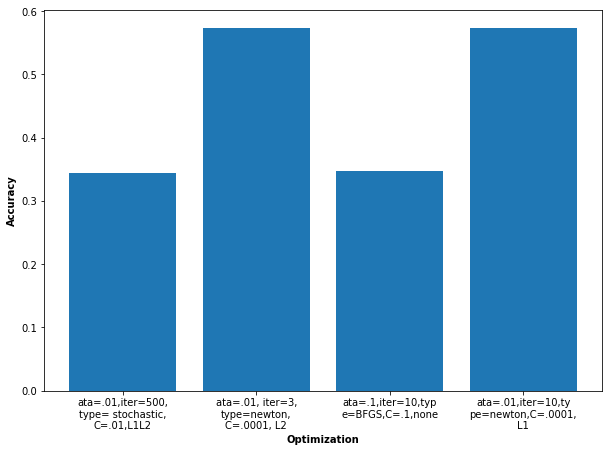

In [923]:
import numpy as np
import matplotlib.pyplot as plt
plt.subplots(figsize=(10, 7))
para=['ata=.01,iter=500, type= stochastic, C=.01,L1L2 ','ata=.01, iter=3, type=newton, C=.0001, L2','ata=.1,iter=10,type=BFGS,C=.1,none','ata=.01,iter=10,type=newton,C=.0001,L1'  ]
acc=[0.34355880353501017,0.572569680489463, 0.34721278042148196,0.5727396329027872]
labels = [ '\n'.join(wrap(l, 18)) for l in para ]
plt.xlabel('Optimization', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.bar(labels,acc) 

the figure above shows the accuracy for variuse optimization Techniques, newton with 10 iteration has the highest accuracy but is the worst in term of time consumtion 



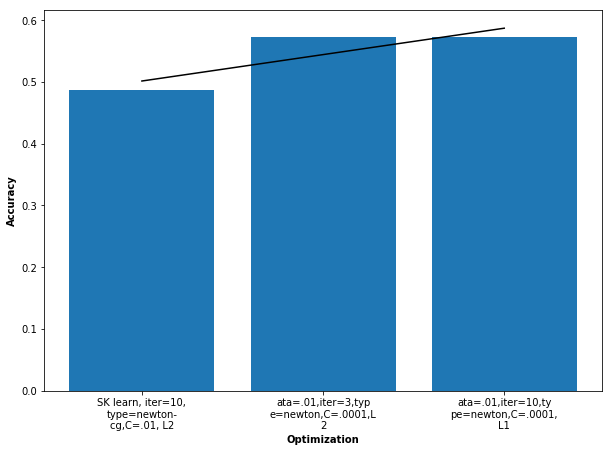

In [921]:
para=['SK learn, iter=10,type=newton-cg,C=.01, L2','ata=.01,iter=3,type=newton,C=.0001,L2','ata=.01,iter=10,type=newton,C=.0001,L1'  ]
x=[0,1,2]
acc=[ 0.48721108089734877,0.572569680489463, 0.5727396329027872]
time=[.15, 3.26, 1.6]
plt.subplots(figsize=(10, 7))
z=np.polyfit(x, acc, 1)
labels = [ '\n'.join(wrap(l, 18)) for l in para ]


plt.bar(labels,acc)
#ax.bar(labels,time,width=0.2,color='g')
plt.xlabel('Optimization', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
p = np.poly1d(z)
plt.plot(x,p(x),color='black')


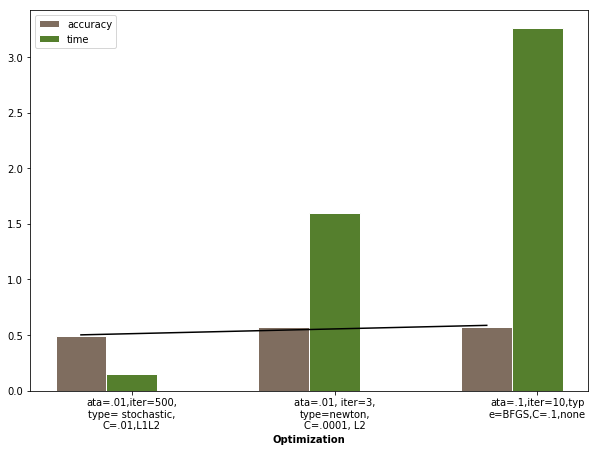

In [925]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [ 0.48721108089734877,0.572569680489463, 0.5727396329027872]
bars2 = [.15, 1.6,3.26]
#bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]
plt.subplots(figsize=(10, 7)) 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='accuracy')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='time')

plt.plot(x,p(x),color='black')
# Add xticks on the middle of the group bars
plt.xlabel('Optimization', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], labels)
 
# Create legend & Show graphic
plt.legend()

plt.show()


### **2. Modeling**
------

### **3. Deployment**
------

### **4. Optimization Using Mean Squared Error**
------

### **5. References**
------